# BLIP vs. CLIP

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue May 30 21:04:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install -q supervision
!pip install -q roboflow
!pip install -q salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 113.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 29.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━

## Download dataset

In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("roboflow-jvuqo").project("fashion-assistant-segmentation")
dataset = project.version(5).download("yolov8")

/content/datasets
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics<=8.0.20`, to intall it `pip install ultralytics<=8.0.20`.


Extracting Dataset Version Zip to fashion-assistant-segmentation-5 in yolov8:: 100%|██████████| 1254/1254 [00:01<00:00, 1232.10it/s]


## BLIP Demo

In [5]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_DIR = f"{dataset.location}/train/images"
SAMPLE_SIZE = 25

In [6]:
from lavis.models import load_model_and_preprocess
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=DEVICE)

100%|██████████| 1.35G/1.35G [01:02<00:00, 23.0MB/s]


In [7]:
import cv2
import PIL
import numpy as np
import supervision as sv
from typing import Tuple
from PIL import Image


def load_image(image_path: str) -> Tuple[PIL.Image.Image, np.ndarray]:
    image_pil = Image.open(image_path).convert("RGB")
    image_numpy = np.asarray(image_pil)
    image_numpy = cv2.cvtColor(image_numpy, cv2.COLOR_RGB2BGR)
    return image_pil, image_numpy

In [17]:
import random

image_paths = sv.list_files_with_extensions(directory=IMAGE_DIR, extensions=["jpg", "jpeg", "png"])
image_paths = random.sample(image_paths, SAMPLE_SIZE)

  0%|          | 0/25 [00:00<?, ?it/s]

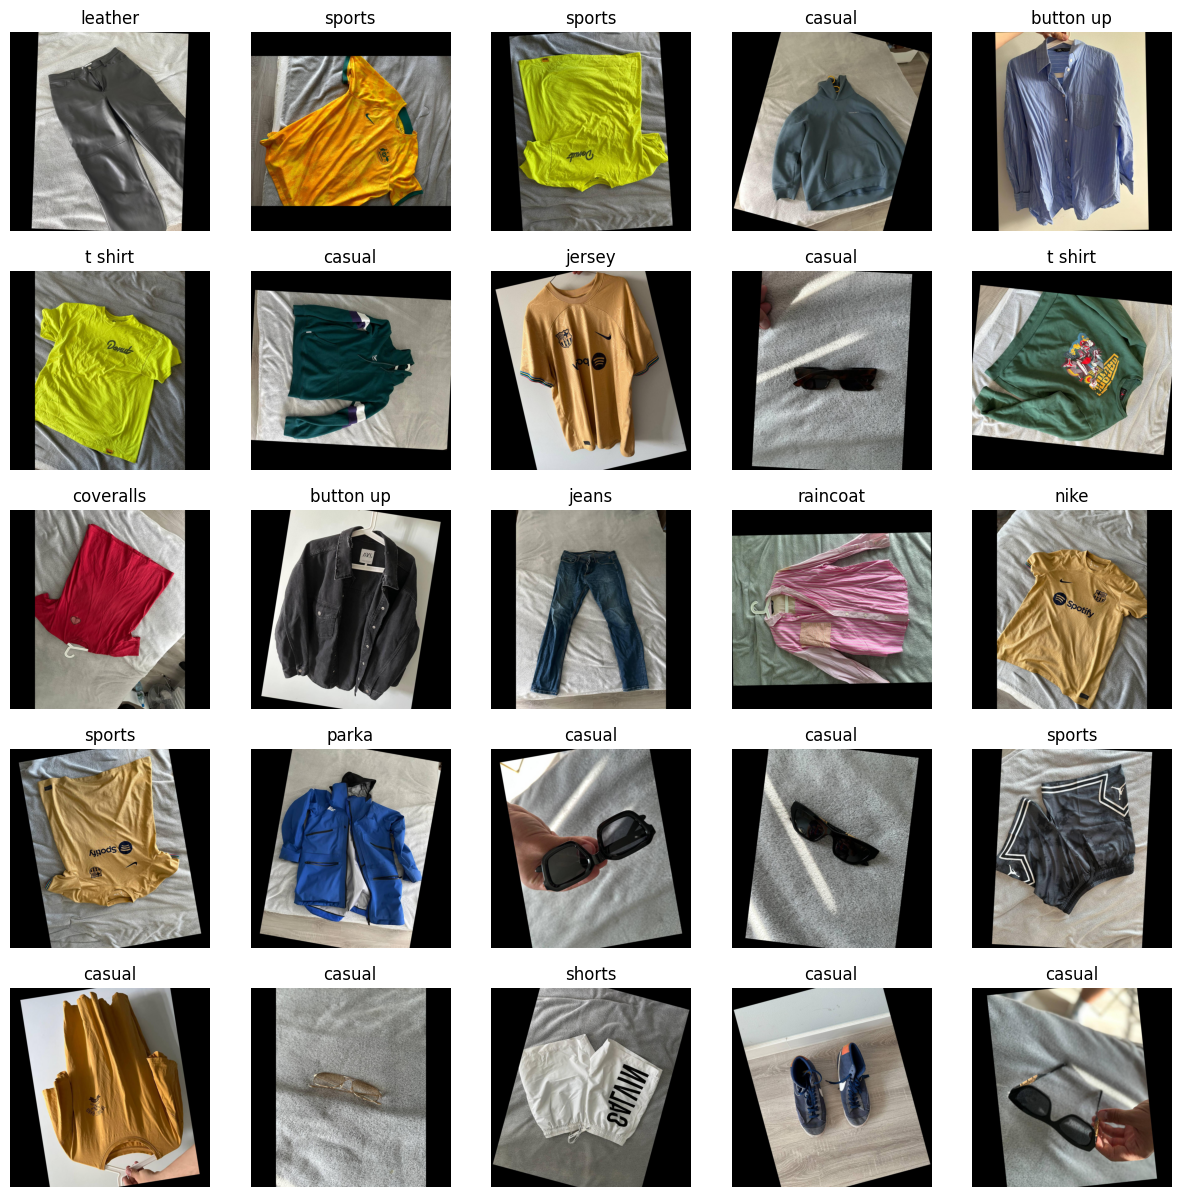

In [9]:
from tqdm.notebook import tqdm

PROMPT = "What is the style of this clothing?"

prompt_processed = txt_processors["eval"](PROMPT)

images_numpy = []
predictions = []

for image_path in tqdm(image_paths):
    image_pil, image_numpy = load_image(image_path=str(image_path))
    image_processed = vis_processors["eval"](image_pil).unsqueeze(0).to(DEVICE)
    prediction = model.predict_answers(samples={"image": image_processed, "text_input": prompt_processed}, inference_method="generate")[0]
    images_numpy.append(image_numpy)
    predictions.append(prediction)

sv.plot_images_grid(images_numpy, grid_size=(5, 5), titles=predictions, size=(15, 15))

  0%|          | 0/25 [00:00<?, ?it/s]

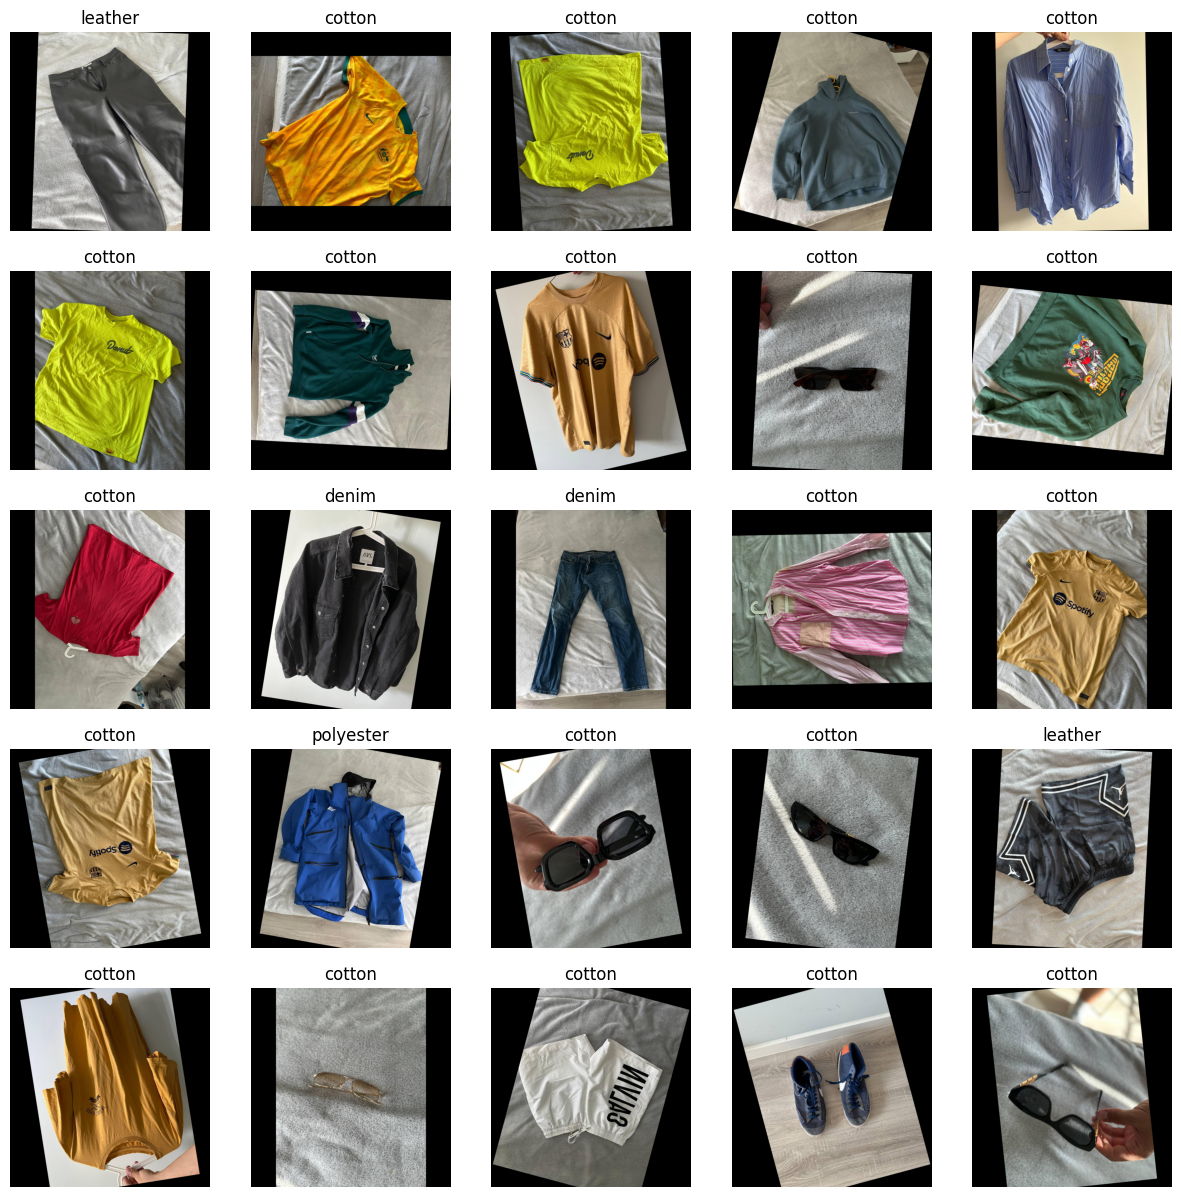

In [10]:
from tqdm.notebook import tqdm

PROMPT = "What material is the clothing made of?"

prompt_processed = txt_processors["eval"](PROMPT)

images_numpy = []
predictions = []

for image_path in tqdm(image_paths):
    image_pil, image_numpy = load_image(image_path=str(image_path))
    image_processed = vis_processors["eval"](image_pil).unsqueeze(0).to(DEVICE)
    prediction = model.predict_answers(samples={"image": image_processed, "text_input": prompt_processed}, inference_method="generate")[0]
    images_numpy.append(image_numpy)
    predictions.append(prediction)

sv.plot_images_grid(images_numpy, grid_size=(5, 5), titles=predictions, size=(15, 15))

  0%|          | 0/25 [00:00<?, ?it/s]

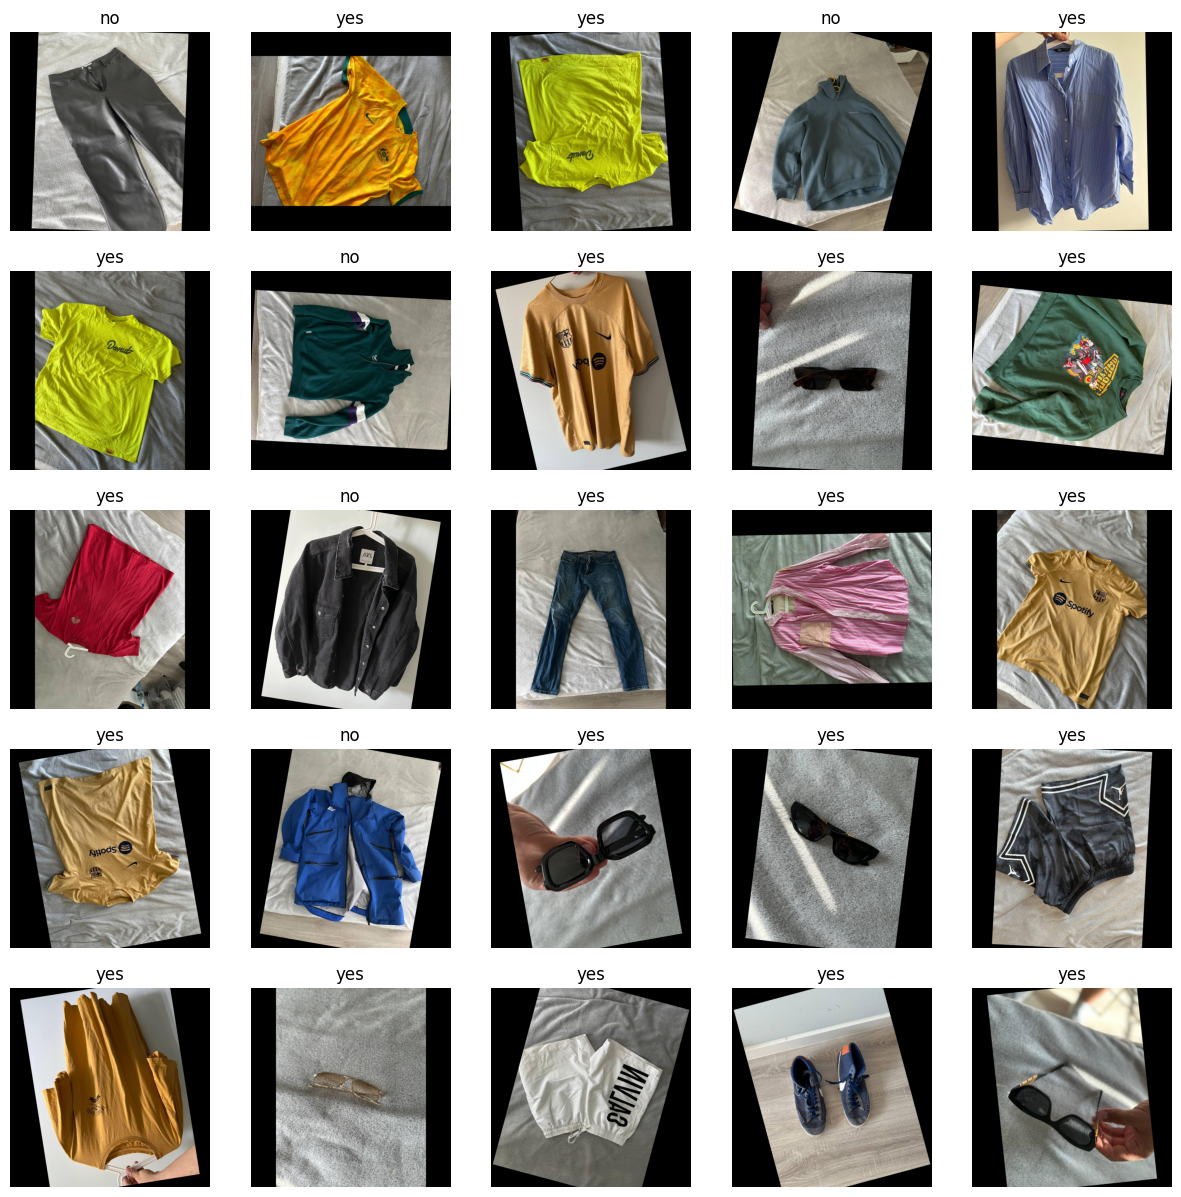

In [11]:
from tqdm.notebook import tqdm

PROMPT = "Is this clothing appropriate for sunny weather?"

prompt_processed = txt_processors["eval"](PROMPT)

images_numpy = []
predictions = []

for image_path in tqdm(image_paths):
    image_pil, image_numpy = load_image(image_path=str(image_path))
    image_processed = vis_processors["eval"](image_pil).unsqueeze(0).to(DEVICE)
    prediction = model.predict_answers(samples={"image": image_processed, "text_input": prompt_processed}, inference_method="generate")[0]
    images_numpy.append(image_numpy)
    predictions.append(prediction)

sv.plot_images_grid(images_numpy, grid_size=(5, 5), titles=predictions, size=(15, 15))

## CLIP Demo

In [15]:
STYLES = [
    'Casual', 
    'Professional', 
    'Athletic', 
    'Streetwear', 
    'Boho',  
    'Vintage', 
    'Punk', 
    'Goth', 
    'Minimalist', 
    'High Fashion', 
    'Country', 
    'Tropical', 
    'Formal'
]

In [13]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

  0%|          | 0/25 [00:00<?, ?it/s]

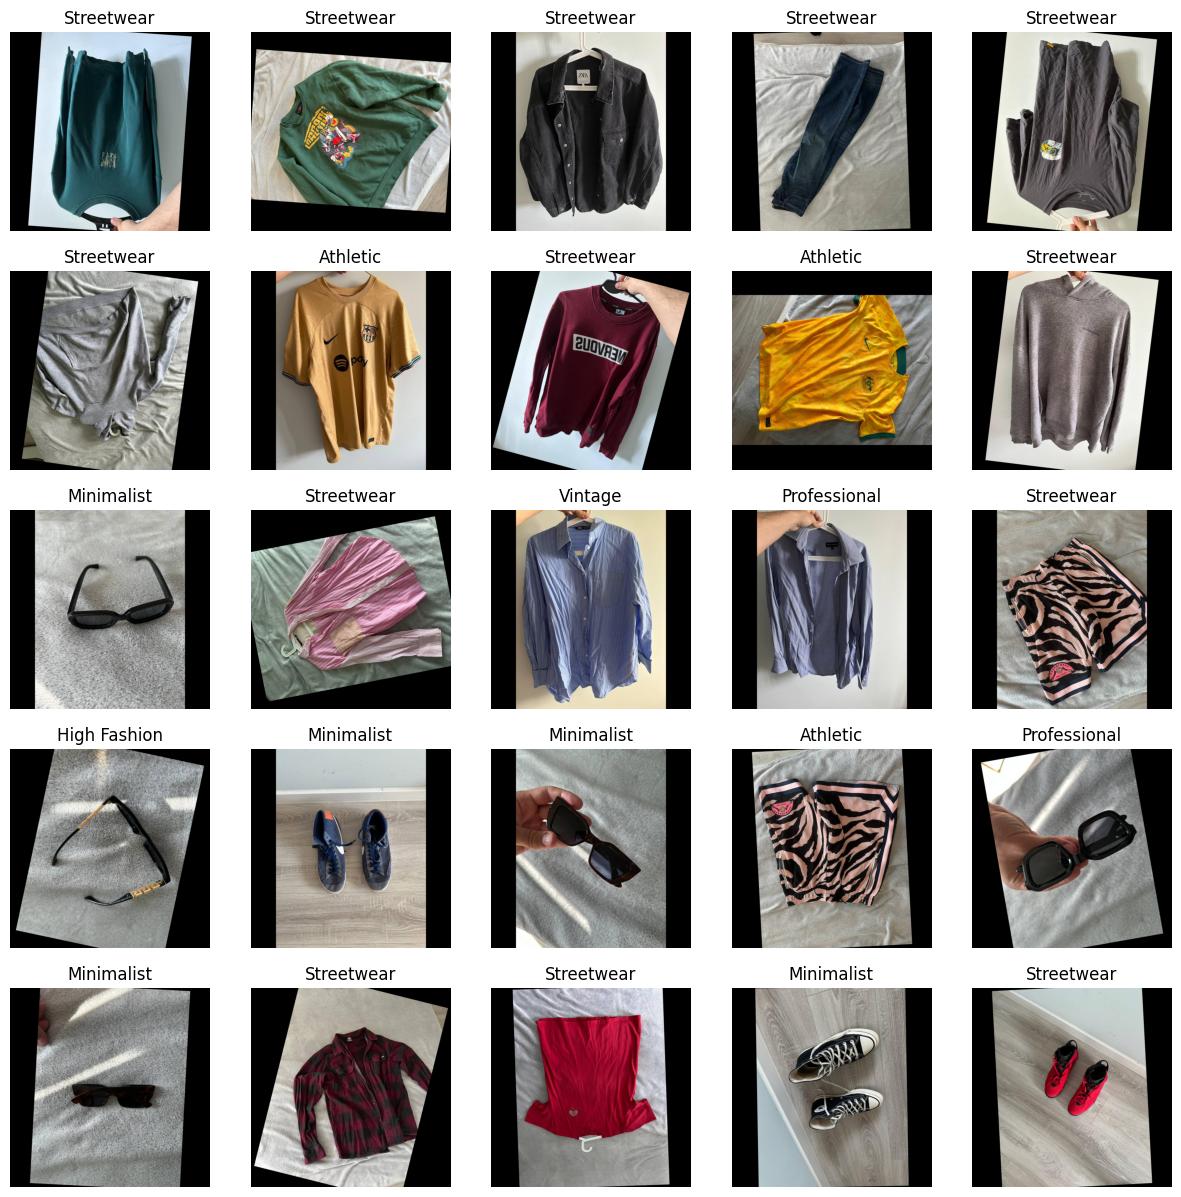

In [18]:
images_numpy = []
predictions = []

for image_path in tqdm(image_paths):
    image_pil, image_numpy = load_image(image_path=str(image_path))
    inputs = processor(text=STYLES, images=image_pil, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    probs = np.squeeze(probs.numpy())
    sort_indices = np.argsort(probs)[::-1]
    sorted_styles = np.array(STYLES)[sort_indices]

    images_numpy.append(image_numpy)
    predictions.append(sorted_styles[0])

sv.plot_images_grid(images_numpy, grid_size=(5, 5), titles=predictions, size=(15, 15))